In [23]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread, imshow
from skimage.color import rgb2gray, rgb2hsv
from skimage.morphology import area_opening
from skimage.exposure import histogram
from skimage.filters import threshold_otsu
import os
from PIL import Image
import cv2
import os
import cv2
import math
import numpy as np
import pandas as pd
from skimage import filters
import pandas as pd

In [24]:
base_path = r'D:\test\BIOM5202_Project\Images\Raw Images\Dataset1\Set1'
file_name_substring_flair = 'flair.png'
file_name_substring_seg = 'seg.png'

All_images_flair = np.zeros((240, 240, 12), dtype=np.uint8)  # Changed dtype to np.uint8
All_images_seg = np.zeros((240, 240, 12), dtype=np.uint8)    # Changed dtype to np.uint8

for folder_number in range(1, 13):
    folder_path = os.path.join(base_path, str(folder_number))

    # Get a list of files in the folder
    files_flair = [file for file in os.listdir(folder_path) if file_name_substring_flair in file]
    files_seg = [file for file in os.listdir(folder_path) if file_name_substring_seg in file]

    # Check if any file contains the specified substring
    if files_flair and files_seg:
        file_path_flair = os.path.join(folder_path, files_flair[0])
        file_path_seg = os.path.join(folder_path, files_seg[0])

        # Open the image files using PIL
        img_flair = np.array(Image.open(file_path_flair), dtype=np.uint8)  # Changed dtype to np.uint8
        img_seg = np.array(Image.open(file_path_seg), dtype=np.uint8)      # Changed dtype to np.uint8

        # Convert the images to grayscale
        img_flair = cv2.cvtColor(img_flair, cv2.COLOR_BGR2GRAY)
        img_seg = cv2.cvtColor(img_seg, cv2.COLOR_BGR2GRAY)

        # Assign the images to the All_images arrays
        All_images_flair[:, :, folder_number - 1] = img_flair
        All_images_seg[:, :, folder_number - 1] = img_seg


In [25]:
def IoU(y_true, y_pred):
    """
    Calculate the Intersection over Union (IoU) of two numpy arrays.

    :param y_true: Ground truth binary array.
    :param y_pred: Predicted binary array.
    :return: IoU score.
    """
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

def dice_similarity(y_true, y_pred):
    """
    Calculate the Dice Similarity Coefficient for two numpy arrays.

    :param y_true: Ground truth binary array.
    :param y_pred: Predicted binary array.
    :return: Dice similarity score.
    """
    intersection = np.logical_and(y_true, y_pred)
    dice_score = 2. * np.sum(intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_score

def draw_intersection_of_binary_images_v3(image1, image2):
    """
    Draw the intersection of two binary images, where intersection is red, non-intersection is white,
    and background is black.

    Parameters:
    image1, image2 (numpy.ndarray): Two binary images of the same size.

    Returns:
    numpy.ndarray: Image highlighting the intersection in red, non-intersection in white, and background in black.
    """
    if image1.shape != image2.shape:
        raise ValueError("The input images must have the same size")

    # Create an image to display the result
    result_image = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)

    # Intersection (red)
    intersection = (image1 == 255) & (image2 == 255)
    result_image[intersection] = [255, 0, 0]

    # Non-intersecting parts of the images (white)
    non_intersection = ((image1 == 255) | (image2 == 255)) & ~intersection
    result_image[non_intersection] = [255, 255, 255]

    # Background remains black (as initialized)

    return result_image

The thereshold using Ostu is equal: 170
The thereshold using maximum intensity-100 is equal: 46.40428819444443
The thereshold using Ostu is equal: 48


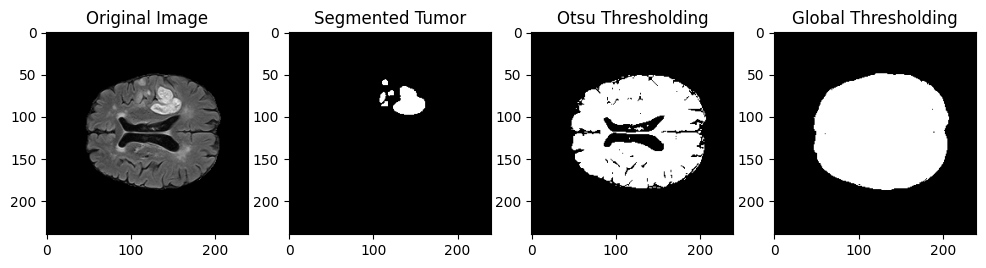

In [26]:
from skimage import filters
# Choose a slice and time point for demonstration
numberOflyer=3
image_slice = All_images_flair[:,:,numberOflyer]
segmented_image=All_images_seg[:,:,numberOflyer]

# Step 1: Get the pixel values
pixel_values = image_slice.flatten()
# Step 2: Remove pixel values between 0 and 20
pixel_values_Without_background = np.where((pixel_values >= 0) & (pixel_values <= 20), 255, pixel_values)


# Reshape the filtered pixel values back to the original image shape
image_filtered = pixel_values_Without_background.reshape(image_slice.shape)
T_ostu = threshold_otsu(image_filtered)
T_Brightest = np.max(image_filtered)-np.mean(image_filtered)


print("The thereshold using Ostu is equal:",T_ostu)
print("The thereshold using maximum intensity-100 is equal:",T_Brightest)

# Apply Gaussian blur to reduce noise
blurred_image = cv2.GaussianBlur(image_slice, (5, 5), 0)

# Otsu's thresholding
T_ostu = threshold_otsu(image_slice)
print("The thereshold using Ostu is equal:",T_ostu)
binary_mask_otsu = image_slice > T_ostu

# Simple global threshold (you can adjust this threshold value)
binary_mask_global = image_slice > T_Brightest


binary_mask_otsu = (image_slice > T_ostu).astype(np.uint8) * 255
binary_mask_global = (image_slice > binary_mask_global).astype(np.uint8) * 255

plt.figure(figsize=(12, 4))
plt.subplot(1, 4, 1), plt.imshow(image_slice, cmap='gray'), plt.title('Original Image')
plt.subplot(1, 4, 2), plt.imshow(segmented_image, cmap='gray'), plt.title('Segmented Tumor')
plt.subplot(1, 4, 3), plt.imshow(binary_mask_otsu, cmap='gray'), plt.title('Otsu Thresholding')
plt.subplot(1, 4, 4), plt.imshow(binary_mask_global, cmap='gray'), plt.title('Global Thresholding')

plt.show()

In [27]:

def draw_intersection_of_binary_images_v3(image1, image2):
    """
    Draw the intersection of two binary images, where intersection is red, non-intersection is white,
    and background is black.

    Parameters:
    image1, image2 (numpy.ndarray): Two binary images of the same size.

    Returns:
    numpy.ndarray: Image highlighting the intersection in red, non-intersection in white, and background in black.
    """
    if image1.shape != image2.shape:
        raise ValueError("The input images must have the same size")

    # Create an image to display the result
    result_image = np.zeros((image1.shape[0], image1.shape[1], 3), dtype=np.uint8)

    # Intersection (red)
    intersection = (image1 == 255) & (image2 == 255)
    result_image[intersection] = [255, 0, 0]

    # Non-intersecting parts of the images (white)
    non_intersection = ((image1 == 255) | (image2 == 255)) & ~intersection
    result_image[non_intersection] = [255, 255, 255]

    # Background remains black (as initialized)

    return result_image




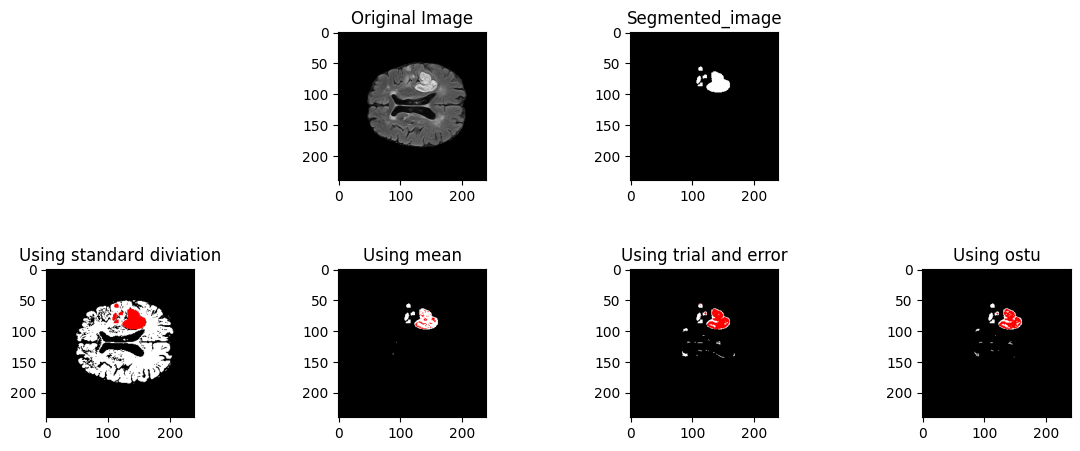

In [28]:


# Assuming you have already defined 'image_slice' somewhere

# Step 1: Get the pixel values
blurred_image = cv2.GaussianBlur(image_slice, (5, 5), 0)
pixel_values = blurred_image.flatten()

# Step 2: Remove pixel values between 0 and 20
pixel_values_filtered = np.where((pixel_values >= 0) & (pixel_values <= 20), 255, pixel_values)

# Reshape the filtered pixel values back to the original image shape
image_filtered = pixel_values_filtered.reshape(image_slice.shape)

# Step 3: Apply Otsu's thresholding on the modified pixel values
T_ostu = filters.threshold_otsu(image_filtered)
T_Brightest_var = math.sqrt(np.var(image_filtered))
T_Brightest_trial = np.max(pixel_values_filtered)-100
T_Brightest_mean = np.mean(image_filtered)

binary_image_var= (image_slice > T_Brightest_var).astype(np.uint8) * 255
binary_image_trial = (image_slice > T_Brightest_trial).astype(np.uint8) * 255
binary_image_mean = (image_slice > T_Brightest_mean).astype(np.uint8) * 255
binary_image_ostu = (image_slice > T_ostu).astype(np.uint8) * 255

Diffrence_image_var=draw_intersection_of_binary_images_v3(binary_image_var,segmented_image)
Diffrence_image_mean=draw_intersection_of_binary_images_v3(binary_image_mean,segmented_image)
Diffrence_image_trial=draw_intersection_of_binary_images_v3(binary_image_trial,segmented_image)
Diffrence_image_ostu=draw_intersection_of_binary_images_v3(binary_image_ostu,segmented_image)



# Display the original, filtered, and thresholded images
plt.figure(figsize=(14, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Adjust row and column spacing
plt.subplot(2, 4, 2)
plt.imshow(image_slice, cmap='gray')
plt.title('Original Image')


plt.subplot(2, 4, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title('Segmented_image')



plt.subplot(2, 4, 5)
plt.imshow(Diffrence_image_var)
plt.title('Using standard diviation')

plt.subplot(2, 4, 6)
plt.imshow(Diffrence_image_mean)
plt.title('Using mean')

plt.subplot(2, 4, 7)
plt.imshow(Diffrence_image_trial)
plt.title('Using trial and error')

plt.subplot(2, 4, 8)
plt.imshow(Diffrence_image_ostu)
plt.title('Using ostu')


plt.show()


In [29]:
# Assuming you have already defined 'All_images_flair', 'All_images_seg', and the draw_intersection_of_binary_images_v3 function

# Create a directory to save resulted images if it doesn't exist
os.makedirs('resulted_images', exist_ok=True)

# Choose a slice and time point for demonstration
for layer_index in range(All_images_flair.shape[2]):
    image_slice = All_images_flair[:, :, layer_index]
    segmented_image = All_images_seg[:, :, layer_index]

    # Step 1: Get the pixel values
    blurred_image = cv2.GaussianBlur(image_slice, (5, 5), 0)
    pixel_values = blurred_image.flatten()

    # Step 2: Remove pixel values between 0 and 20
    pixel_values_filtered = np.where((pixel_values >= 0) & (pixel_values <= 20), 255, pixel_values)

    # Reshape the filtered pixel values back to the original image shape
    image_filtered = pixel_values_filtered.reshape(image_slice.shape)

    # Step 3: Apply Otsu's thresholding on the modified pixel values
    T_ostu = filters.threshold_otsu(image_filtered)
    T_Brightest_var = math.sqrt(np.var(image_filtered))
    T_Brightest_trial = np.max(pixel_values_filtered) - 100
    T_Brightest_mean = np.mean(image_filtered)

    binary_image_var = (image_slice > T_Brightest_var).astype(np.uint8) * 255
    binary_image_trial = (image_slice > T_Brightest_trial).astype(np.uint8) * 255
    binary_image_mean = (image_slice > T_Brightest_mean).astype(np.uint8) * 255
    binary_image_ostu = (image_slice > T_ostu).astype(np.uint8) * 255

    Diffrence_image_var = draw_intersection_of_binary_images_v3(binary_image_var, segmented_image)
    Diffrence_image_mean = draw_intersection_of_binary_images_v3(binary_image_mean, segmented_image)
    Diffrence_image_trial = draw_intersection_of_binary_images_v3(binary_image_trial, segmented_image)
    Diffrence_image_ostu = draw_intersection_of_binary_images_v3(binary_image_ostu, segmented_image)

    # Display the original, filtered, and thresholded images
    plt.figure(figsize=(14, 5))
    plt.subplots_adjust(wspace=0.4, hspace=0.6)  # Adjust row and column spacing

    plt.subplot(2, 4, 2)
    plt.imshow(image_slice, cmap='gray')
    plt.title('Original Image')

    plt.subplot(2, 4, 3)
    plt.imshow(segmented_image, cmap='gray')
    plt.title('Segmented_image')

    plt.subplot(2, 4, 5)
    plt.imshow(Diffrence_image_var)
    plt.title('Using standard diviation')

    plt.subplot(2, 4, 6)
    plt.imshow(Diffrence_image_mean)
    plt.title('Using mean')

    plt.subplot(2, 4, 7)
    plt.imshow(Diffrence_image_trial)
    plt.title('Using trial and error')

    plt.subplot(2, 4, 8)
    plt.imshow(Diffrence_image_ostu)
    plt.title('Using ostu')

    # Save the subplot image with the name of layer_index
    plt.savefig(os.path.join('resulted_images', f'binary_masks_folder_{layer_index}.png'))

    # Close the figure to avoid memory leaks
    plt.close()


In [30]:


# Assuming you have the IoU and dice_similarity functions already defined

# Create a directory to save resulted images if it doesn't exist
os.makedirs('resulted_images', exist_ok=True)

IoU_values = np.zeros((12, 4))
dice_similarity_values = np.zeros((12, 4))

# Choose a slice and time point for demonstration
for layer_index in range(All_images_flair.shape[2]):
    image_slice = All_images_flair[:, :, layer_index]
    segmented_image = All_images_seg[:, :, layer_index]

    # Step 1: Get the pixel values
    blurred_image = cv2.GaussianBlur(image_slice, (5, 5), 0)
    pixel_values = blurred_image.flatten()

    # Step 2: Remove pixel values between 0 and 20
    pixel_values_filtered = np.where((pixel_values >= 0) & (pixel_values <= 20), 255, pixel_values)

    # Reshape the filtered pixel values back to the original image shape
    image_filtered = pixel_values_filtered.reshape(image_slice.shape)

    # Step 3: Apply Otsu's thresholding on the modified pixel values
    T_ostu = filters.threshold_otsu(image_filtered)
    T_Brightest_var = math.sqrt(np.var(image_filtered))
    T_Brightest_trial = np.max(pixel_values_filtered) - 100
    T_Brightest_mean = np.mean(image_filtered)

    binary_image_var = (image_slice > T_Brightest_var).astype(np.uint8) * 255
    binary_image_trial = (image_slice > T_Brightest_trial).astype(np.uint8) * 255
    binary_image_mean = (image_slice > T_Brightest_mean).astype(np.uint8) * 255
    binary_image_ostu = (image_slice > T_ostu).astype(np.uint8) * 255

    IoU_values[layer_index, 0] = IoU(segmented_image, binary_image_var)
    IoU_values[layer_index, 1] = IoU(segmented_image, binary_image_mean)
    IoU_values[layer_index, 2] = IoU(segmented_image, binary_image_trial)
    IoU_values[layer_index, 3] = IoU(segmented_image, binary_image_ostu)

    dice_similarity_values[layer_index, 0] = IoU(segmented_image, binary_image_var)
    dice_similarity_values[layer_index, 1] = IoU(segmented_image, binary_image_mean)
    dice_similarity_values[layer_index, 2] = IoU(segmented_image, binary_image_trial)
    dice_similarity_values[layer_index, 3] = IoU(segmented_image, binary_image_ostu)

IoU_df = pd.DataFrame(IoU_values, columns=['IoU_var', 'IoU_mean', 'IoU_trial', 'IoU_ostu'])
dice_similarity_df = pd.DataFrame(dice_similarity_values, columns=['Dice_var', 'Dice_mean', 'Dice_trial', 'Dice_ostu'])

# Save the DataFrames to CSV files with custom formatting
IoU_df.to_csv('resulted_images/IoU_values.csv', sep='|', index_label='Layer', header=True)
dice_similarity_df.to_csv('resulted_images/dice_similarity_values.csv', sep='|', index_label='Layer', header=True)

# Display the DataFrames

# Calculate the mean for each column
ioU_column_means = np.mean(IoU_values, axis=0)
dice_similarity_column_means = np.mean(dice_similarity_values, axis=0)

print("\nIoU Column Means:")
print(ioU_column_means)

print("\nDice Similarity Column Means:")
print(dice_similarity_column_means)

print("IoU Values:")
print(IoU_df)

print("\nDice Similarity Values:")
print(dice_similarity_df)



IoU Column Means:
[0.15121772 0.12352187 0.5355966  0.42253   ]

Dice Similarity Column Means:
[0.15121772 0.12352187 0.5355966  0.42253   ]
IoU Values:
     IoU_var  IoU_mean  IoU_trial  IoU_ostu
0   0.126024  0.096436   0.561579  0.744235
1   0.044749  0.080089   0.058929  0.168733
2   0.103043  0.486989   0.752715  0.712435
3   0.083672  0.146974   0.556027  0.519091
4   0.186406  0.083155   0.591507  0.452991
5   0.231312  0.322413   0.925105  0.821296
6   0.108951  0.014337   0.326937  0.124014
7   0.141222  0.040394   0.426362  0.382773
8   0.193774  0.071358   0.523790  0.343052
9   0.136336  0.065642   0.370138  0.315175
10  0.199090  0.038516   0.437544  0.239292
11  0.260034  0.035960   0.896525  0.247273

Dice Similarity Values:
    Dice_var  Dice_mean  Dice_trial  Dice_ostu
0   0.126024   0.096436    0.561579   0.744235
1   0.044749   0.080089    0.058929   0.168733
2   0.103043   0.486989    0.752715   0.712435
3   0.083672   0.146974    0.556027   0.519091
4   0.186406  

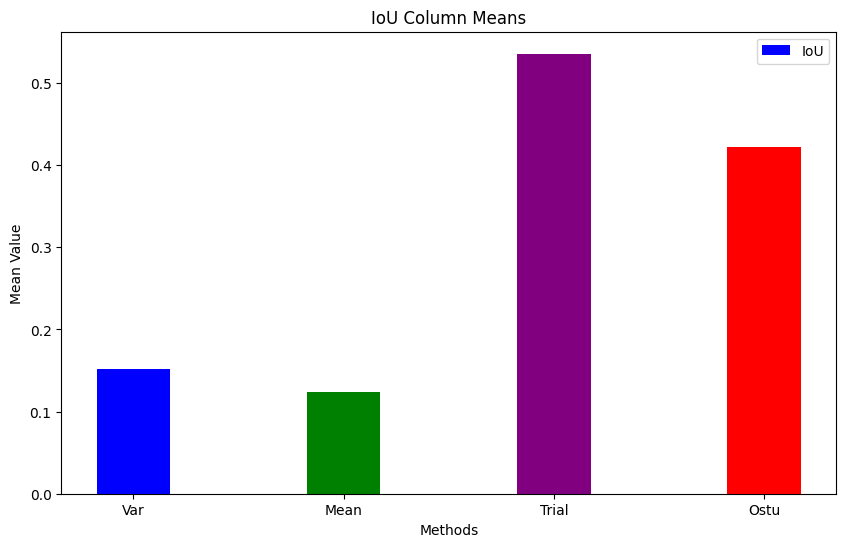

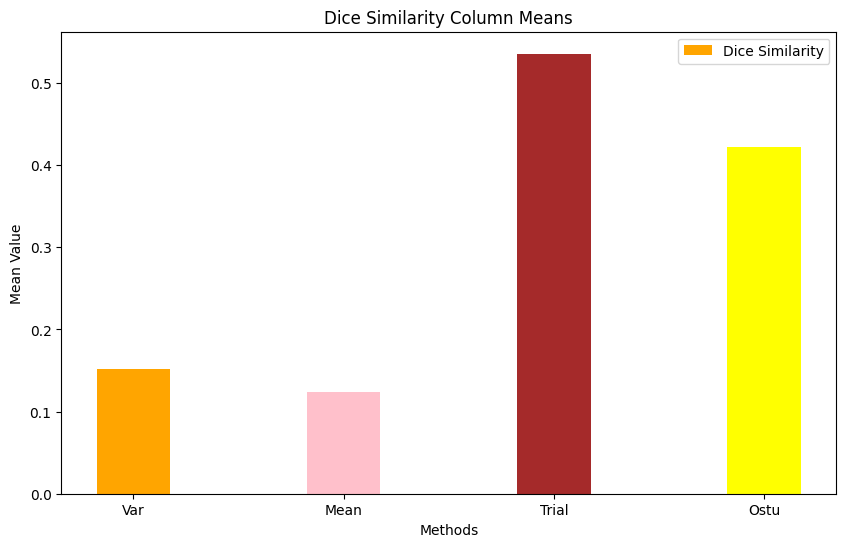

In [31]:
# Bar graph for IoU column means
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(ioU_column_means))
colors_ioU = ['blue', 'green', 'purple', 'red']  # Adjust colors as needed
plt.bar(index, ioU_column_means, bar_width, label='IoU', color=colors_ioU)

plt.xlabel('Methods')
plt.ylabel('Mean Value')
plt.title('IoU Column Means')
plt.xticks(index, ('Var', 'Mean', 'Trial', 'Ostu'))
plt.legend()
plt.savefig('resulted_images/bar_plot_IoU_data_set.png')
plt.show()

# Bar graph for Dice Similarity column means
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(dice_similarity_column_means))
colors_dice_similarity = ['orange', 'pink', 'brown', 'yellow']  # Adjust colors as needed
plt.bar(index, dice_similarity_column_means, bar_width, label='Dice Similarity', color=colors_dice_similarity)

plt.xlabel('Methods')
plt.ylabel('Mean Value')
plt.title('Dice Similarity Column Means')
plt.xticks(index, ('Var', 'Mean', 'Trial', 'Ostu'))
plt.legend()
plt.savefig('resulted_images/bar_plot_dice_similarity_data_set.png')
plt.show()

https://medium.com/swlh/image-processing-with-python-image-segmentation-using-thresholding-methods-423ecdaf8ab4